# PieceWise Exponential + Proportional Hazard

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai.data_block import DataBunch, DatasetType
from fastai.basics import Learner

import numpy as np
from sklearn.model_selection import train_test_split

from scipy.stats import gaussian_kde
from scipy.optimize import root_scalar

from torch.utils.data import Dataset, DataLoader
from torch import optim

import matplotlib.pyplot as plt

from lifelines.datasets import load_rossi
from lifelines import KaplanMeierFitter, PiecewiseExponentialFitter

%matplotlib inline

In [3]:
def get_rossi_dataset():
    df = load_rossi()

    T_train = df.pop("week").values
    E_train = df.pop("arrest").values
    print(df.columns)
    X_train = df.values

    return X_train, T_train, E_train


x_train, t_train, e_train = get_rossi_dataset()
print(x_train.shape, t_train.shape, e_train.shape)
max_t = t_train.max()

split = train_test_split(x_train, t_train, e_train, test_size=0.2)
x_train, x_test, t_train, t_test, e_train, e_test = split
split = train_test_split(x_train, t_train, e_train, test_size=0.1)
x_train, x_val, t_train, t_val, e_train, e_val = split

Index(['fin', 'age', 'race', 'wexp', 'mar', 'paro', 'prio'], dtype='object')
(432, 7) (432,) (432,)


[15.6 24.2 35.  45. ]


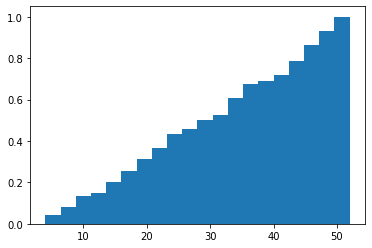

In [4]:
breakpoints = np.percentile(t_train[(e_train).astype(bool)], [20, 40, 60, 80])
print(breakpoints)

plt.hist(t_train[(e_train).astype(bool)], 20, density=True, cumulative=True)
plt.show()

In [6]:
class Data(Dataset):
    def __init__(self, x, t, e, breakpoints, mean, std):
        super().__init__()
        self.x, self.t, self.e = x, t, e
        self.mean, self.std = torch.Tensor(mean), torch.Tensor(std)
        self.b = breakpoints
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
#         import pdb; pdb.set_trace()
        x = torch.Tensor(self.x[i])
#         import pdb; pdb.set_trace()
        x = (x - self.mean) / self.std
        time = torch.Tensor([self.t[i]])
        t_section = torch.LongTensor([np.searchsorted(self.b, self.t[i])])
        e = torch.Tensor([self.e[i]])
        return (x, time, t_section.squeeze()), e
    
mean, std = x_train.mean(0), x_train.std(0)
train_ds = Data(x_train, t_train, e_train, breakpoints, mean, std)
val_ds = Data(x_val, t_val, e_val, breakpoints, mean, std)
test_ds = Data(x_test, t_test, e_test, breakpoints, mean, std)

bs = 96
db = DataBunch.create(train_ds, val_ds, bs=bs)
test_db = DataLoader(test_ds, batch_size=bs)

In [7]:
class PieceWiseHazard(nn.Module):
    def __init__(self, breakpoints, max_t):
        super().__init__()
        self.logλ = nn.Embedding(len(breakpoints)+1, 1)
        self.breakpoints = torch.Tensor([0] + breakpoints.tolist())
        bounded_bp = [0] + breakpoints.tolist() + [max_t]
        self.widths = torch.Tensor(np.diff(bounded_bp).tolist())[:,None]
        self.zero = torch.zeros(1,1)
        self.max_t = max_t
        
    def cumulative_hazard(self, t, t_section):
        λ = torch.exp(self.logλ.weight)

        # cumulative hazard 
        cum_hazard = λ * self.widths
        cum_hazard = cum_hazard.cumsum(0)
        cum_hazard = torch.cat([self.zero, cum_hazard])
        cum_hazard_sec = cum_hazard[t_section]
        
        δ_t = t - self.breakpoints[t_section][:,None]
        
        return cum_hazard_sec + λ[t_section] * δ_t
        
        
    def forward(self, t, t_section):
        return self.logλ(t_section), self.cumulative_hazard(t, t_section)
    
    def plot_survival_function(self):
        # get the times and time sections for survival function
        t_query = np.arange(self.max_t+10)
        breakpoints = self.breakpoints[1:].cpu().numpy()
        t_sec_query = np.searchsorted(breakpoints, t_query)
        # convert to pytorch tensors
        t_query = torch.Tensor(t_query)[:,None]
        t_sec_query = torch.LongTensor(t_sec_query)
        
        # calculate cumulative hazard according to above
        cum_haz = self.cumulative_hazard(t_query, t_sec_query)
        surv_fun = torch.exp(-cum_haz).detach().cpu().numpy()
        
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t_query, surv_fun)
#         plt.show()
        
    def plot_hazard(self):
        width = self.widths.cpu().numpy().squeeze()
        x = self.breakpoints.cpu().numpy().squeeze()
        λ = torch.exp(self.logλ.weight)
        y = λ.detach().cpu().numpy().squeeze()
        # plot
        plt.figure(figsize=(12,5))
        plt.bar(x, y, width, align='edge')
        plt.show()

In [8]:
class ProportionalHazard(nn.Module):
    def __init__(self, breakpoints, max_t, dim, h=()):
        super().__init__()
        self.baseλ = PieceWiseHazard(breakpoints, max_t)
        nodes = (dim,) + h + (1,)
        self.layers = [nn.Linear(a,b, bias=False) for a,b in zip(nodes[:-1], nodes[1:])]
        self.max_t = max_t
        
    def forward(self, x, t, t_section):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        log_hazard = self.layers[-1](x)
        logλ, Λ = self.baseλ(t, t_section)
        logλ += log_hazard
        Λ = torch.exp(log_hazard + torch.log(Λ))
        return logλ, Λ
    
    def plot_survival_function(self, x):
        x = torch.Tensor(x)
        if len(x.shape) < 2:
            x = x[None, :]
        # get the times and time sections for survival function
        t_query = np.arange(self.max_t+10)
        breakpoints = self.baseλ.breakpoints[1:].cpu().numpy()
        t_sec_query = np.searchsorted(breakpoints, t_query)
        # convert to pytorch tensors
        t_query = torch.Tensor(t_query)[:,None]
        t_sec_query = torch.LongTensor(t_sec_query)
        
        
        # calculate cumulative hazard according to above
        λ, cum_haz = self.forward(x, t_query, t_sec_query)
        surv_fun = torch.exp(-cum_haz).detach().cpu().numpy()
        
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t_query, surv_fun)

In [9]:
def loss(params, e):
    logλ, Λ = params # unpack the estimates parameters
    log_lik = e * logλ - Λ
    return -log_lik.mean()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


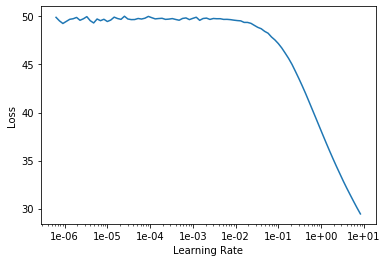

In [10]:
model = ProportionalHazard(breakpoints, t_train.max(), x_train.shape[1])
learner = Learner(db, model, loss_func=loss)
# wd = 1e-4
learner.lr_find()
learner.recorder.plot(skip_end=0)

In [11]:
epochs = 40
learner.fit_one_cycle(epochs, max_lr=2)

epoch,train_loss,valid_loss,time
0,46.384586,34.146030,00:00
1,40.209522,23.170523,00:00
2,33.811680,12.539477,00:00
3,27.605543,5.828071,00:00
4,22.463356,3.036703,00:00
5,18.591583,2.270426,00:00
6,15.724029,2.216608,00:00
7,13.553782,2.335914,00:00
8,11.879812,2.445920,00:00
9,10.557687,2.495793,00:00


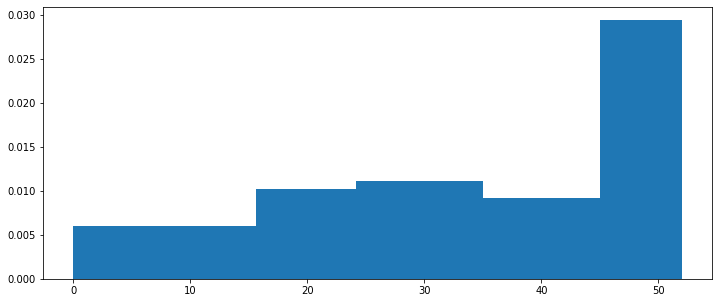

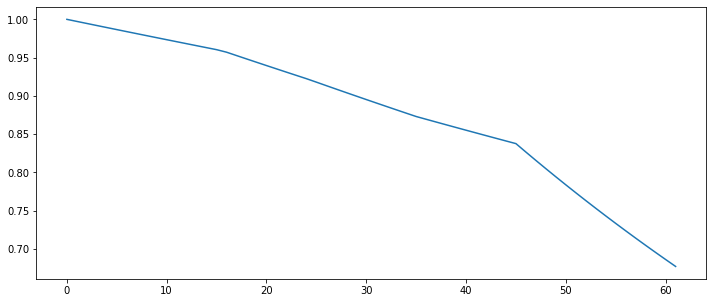

In [12]:
learner.model.baseλ.plot_hazard()
plt.show()
learner.model.plot_survival_function(x_train[:1])
plt.show()
# learner.model.plot_survival_function()

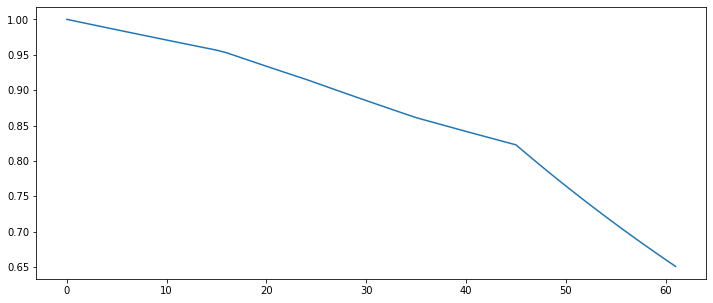

In [33]:
learner.model.plot_survival_function(x_test[0])
plt.show()

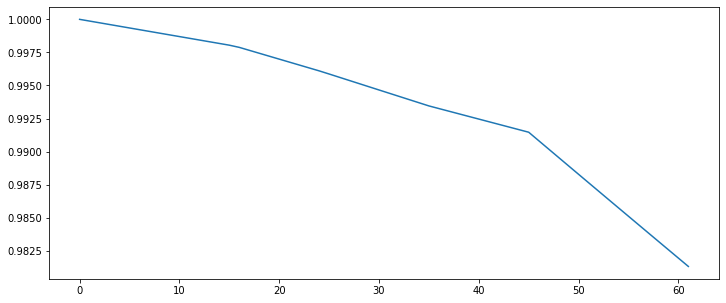

In [36]:
learner.model.plot_survival_function(x_test[2])
plt.show()

Lifelines model for comparison:

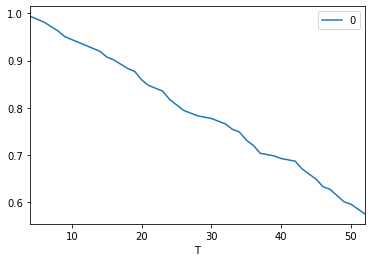

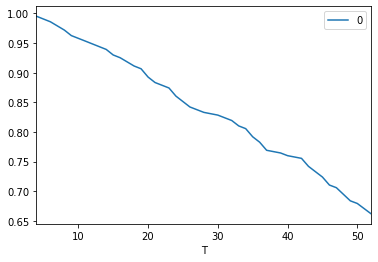

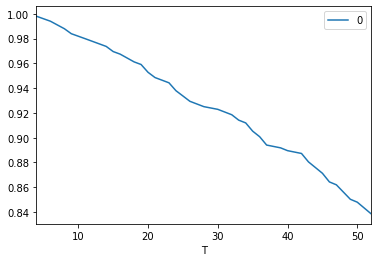

In [37]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
data = pd.concat([pd.DataFrame(x_train), pd.DataFrame({'duration':t_train}), pd.DataFrame({'event':e_train})], axis=1)
cph.fit(data, 'duration', 'event')

# plot survival functions with same data as above
cph.predict_survival_function(x_train[:1]).plot()
plt.show()
cph.predict_survival_function(x_test[:1]).plot()
plt.show()
cph.predict_survival_function(x_test[2:3]).plot()
plt.show()